<a href="https://colab.research.google.com/github/vinayprabhu/hate_scaling/blob/main/code/hateanalysis_400M_2Ben.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GOAL: The goal of this notebook is to:
- Subsample 3.1/12.8 million alt-text descriptions from LAION-400M and LAION2B-En datasets
- Pass it through [pysentimiento](https://arxiv.org/abs/2106.09462) that outputs a 1x3 vector capturing ```['P_hateful', 'P_targeted', 'P_aggressive']```
- A walk-through of all the results and (meta)datasets curated

**(TW)**: Some of the alt-text descriptions you may encounter below are misogynistic and downright 🤮

# 1: Standard imports (This is my customized default first-cell)

In [ ]:
from psutil import virtual_memory
# Make sure to run it on a high-memory instance
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

from scipy.linalg import block_diag
import seaborn as sns
# Numpy aesthetics
np.set_printoptions(suppress=True)
from collections import Counter
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import itertools
%precision 6
#############################################
import sys
import importlib
importlib.reload(sys)
#######################
from google.colab import drive
drive.flush_and_unmount()
import os
drive.mount('/gdrive', force_remount=True)
# Enter your own proj_dir here
proj_dir='/gdrive/My Drive/Colab Notebooks/0_laion_dataset/'
os.chdir(proj_dir)

Your runtime has 27.3 gigabytes of available RAM



<ipython-input-1-1f23c3cc2486>:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


Mounted at /gdrive


# Download the LAION datasets

Source: https://laion.ai/laion-400-open-dataset/


*We produced the dataset in several formats to address the various use cases*: 
- A 50GB url+caption metadata dataset in parquet files. This can be used to compute statistics and redownload part of the dataset
- A 10TB webdataset with 256×256 images, captions and metadata. This is a full version of the dataset, that can be used directly for training
- A 1TB set of the 400M text and image clip embeddings, useful to rebuild new knn indices
- Two 4GB knn indices allowing to easily search in the dataset + two higher quality 16GB knn indices (running in the webdemo)
URL and caption metadata dataset.

We provide 32 parquet files of size around 1GB (total 50GB) with the image URLs, the associated texts and additional metadata in the following format:

SAMPLE_ID | URL | TEXT | LICENSE | NSFW | similarity | WIDTH | HEIGHT

where

- SAMPLE_ID:   A unique identifier
LICENSE:   If a Creative Commons License could be extracted from the image data, we name it here like e.g. “creativecommons.org/licenses/by-nc-sa/3.0/” – otherwise you’ll find it here a “?”
- NSFW: CLIP had been used to estimate if the image has NSFW content. The estimation has been pretty conservative, reducing the number of false negatives at the cost of more false positives. Possible values are “UNLIKELY”, “UNSURE” and “NSFW”
- similarity: Value of the cosine similarity between the text and image embedding
- WIDTH and HEIGHT: image size as the image was embedded. Originals that were larger than 4K size were resized to 4K

*This metadata dataset is best used to redownload the whole dataset or a subset of it. The img2dataset tool can be used to efficiently download such subsets*.

Source of the parquet files:
https://the-eye.eu/public/AI/cah/laion400m-met-release/laion400m-meta/


```
!wget http://3080.rom1504.fr/cah/cah_dataframe_unique/part-00000-4d76554c-2d66-4112-9420-0bb9d725a79d-c000.snappy.parquet
!wget https://the-eye.eu/public/AI/cah/laion400m-met-release/laion400m-meta/part-00000-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet
!wget -m -np -c -U "eye02" -w 2 -R "index.html*" "https://the-eye.eu/public/AI/cah/laion400m-met-release/laion400m-meta/"

# LAION-2B-En
!git lfs install
!git clone https://huggingface.co/datasets/laion/laion2B-en
```



## Now, let us take a look at the individual parquet files constituting these datasets:

- LAION-400M is split into 32 parquet files
- LAION-2B-En has 128 parquet files

In [ ]:
# parquet_list=[]
# import os
# for root, dirs, files in os.walk(os.getcwd()):
#     for file in files:
#         if file.endswith(".snappy.parquet"):
#              parquet_list.append(os.path.join(root, file))
# len(parquet_list)
# This list has been saved in a nice readable dataframe that you can simply load:
data_dir='/gdrive/My Drive/Colab Notebooks/0_laion_dataset' # This will vary based on your env
df_parquet=pd.read_csv('df_400m_2b_parquet.csv')
df_parquet

,dataset,file_id,file_size_GB,file_loc
0,400m,400m_0,1.6794,/the-eye.eu/public/AI/cah/laion400m-met-releas...
1,400m,400m_1,1.6800,/the-eye.eu/public/AI/cah/laion400m-met-releas...
2,400m,400m_2,1.6792,/the-eye.eu/public/AI/cah/laion400m-met-releas...
3,400m,400m_3,1.6797,/the-eye.eu/public/AI/cah/laion400m-met-releas...
4,400m,400m_4,1.6797,/the-eye.eu/public/AI/cah/laion400m-met-releas...
...,...,...,...,...
155,2B,2B_123,2.5123,/LAION-2Ben/laion2B-en/part-00122-5114fd87-297...
156,2B,2B_124,2.5122,/LAION-2Ben/laion2B-en/part-00104-5114fd87-297...
157,2B,2B_125,2.5120,/LAION-2Ben/laion2B-en/part-00102-5114fd87-297...
158,2B,2B_126,2.5120,/LAION-2Ben/laion2B-en/part-00113-5114fd87-297...


In [ ]:
df_parquet['parquet_loc']=data_dir+df_parquet.file_loc
df_parquet.groupby('dataset')['file_size_GB'].describe(), df_parquet.groupby('dataset')['file_size_GB'].sum()

(         count      mean       std     min       25%     50%     75%     max
 dataset                                                                     
 2B       128.0  2.512508  0.000356  2.5116  2.512275  2.5125  2.5128  2.5132
 400m      32.0  1.679731  0.000330  1.6792  1.679500  1.6797  1.6800  1.6806,
 dataset
 2B      321.6010
 400m     53.7514
 Name: file_size_GB, dtype: float64)

In [ ]:
parquet_list_400m=df_parquet.parquet_loc.values[0:32]
parquet_list_2b=df_parquet.parquet_loc.values[32:]
file_0_400m=parquet_list_400m[0]
file_0_2b=parquet_list_2b[0]
print([file_0_400m,file_0_2b])

['/gdrive/My Drive/Colab Notebooks/0_laion_dataset/the-eye.eu/public/AI/cah/laion400m-met-release/laion400m-meta/part-00000-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet', '/gdrive/My Drive/Colab Notebooks/0_laion_dataset/LAION-2Ben/laion2B-en/part-00026-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet']


In [ ]:
!pip install --quiet pytictoc
from pytictoc import TicToc
t = TicToc()

Now, let us look at how the _raw_ parquet files look like:

In [ ]:
t.tic()
df_400m_0 = pd.read_parquet(file_0_400m)
print(df_400m_0.shape)
t.toc()
df_400m_0.head(4)

(12933524, 8)
Elapsed time is 30.278816 seconds.


,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity
0,1.581282e+12,http://media.rightmove.co.uk/148k/147518/58718...,View EPC Rating Graph for this property,109.0,100.0,?,UNSURE,0.312813
1,1.060015e+12,https://thumbs.ebaystatic.com/images/g/DYEAAOS...,Silverline Air Framing Nailer 90mm 10 - 12 Gau...,225.0,225.0,?,UNLIKELY,0.312485
2,3.372497e+12,https://farm1.staticflickr.com/784/40182677504...,Anhui Mountains,800.0,514.0,?,UNLIKELY,0.316512
3,3.820200e+11,https://t2.ftcdn.net/jpg/00/58/35/35/240_F_583...,Acute pain in a woman knee,257.0,240.0,?,UNLIKELY,0.344278


In [ ]:
t.tic()
df_2b_0 = pd.read_parquet(file_0_2b)
print(df_2b_0.shape)
t.toc()
df_2b_0.head(4)

(18141894, 8)
Elapsed time is 48.373117 seconds.


,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity
0,3.605777e+12,https://i.ebayimg.com/thumbs/images/g/kHAAAOSw...,DAREDEVIL / VOL 1 / 285 / 1990 / MARVEL COMICS...,152.0,225.0,?,UNLIKELY,0.349755
1,7.365890e+11,http://s7d9.scene7.com/is/image/BedBathandBeyo...,Avanti Shower Curtains,400.0,400.0,?,UNLIKELY,0.338636
2,5.892820e+11,https://thumb101.shutterstock.com/image-photo/...,Beautiful young woman wearing white wool hat a...,450.0,320.0,?,UNLIKELY,0.336294
3,3.640733e+12,https://www.hplaptopbattery.com.au/rr_big/pic_...,Battery for HP HSTNN-PB6T laptop,730.0,459.0,?,UNLIKELY,0.340967


Neat! Now ```pip install``` [pysentimiento](https://arxiv.org/abs/2106.09462) and ```pytictoc```

In [ ]:
# !pip install --upgrade accelerate
!pip install --quiet pysentimiento

Getting acquainted with ```pysentimiento```:

Let us initialize the pysentimiento analyzer and feed in an example to see what it produces ...

In [ ]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="hate_speech", lang="en")
df_2b_0.TEXT.values[0],analyzer.predict(df_2b_0.TEXT.values[0])

('DAREDEVIL / VOL 1 / 285 / 1990 / MARVEL COMICS / US-Comics',
 AnalyzerOutput(output=[], probas={hateful: 0.017, targeted: 0.012, aggressive: 0.011}))

In [ ]:
import sys
print("Python version")
# See: https://github.com/pysentimiento/pysentimiento/issues/50
print (sys.version)

Python version
3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [ ]:
df_400m_0.TEXT.values[0],analyzer.predict(df_400m_0.TEXT.values[0])

('View EPC Rating Graph for this property',
 AnalyzerOutput(output=[], probas={hateful: 0.015, targeted: 0.012, aggressive: 0.011}))

# 3: The random sampling experiment 

- Generate 0.1 million random indices per parquet file
- Save these 0.1 million random indices of the associated parquet files
- Parse the parquet file and extract the image (alt)textual descriptions pertaining to these 1e5 random indices as a numpy tensor
- Pass the alt-text tensor through the hate-analyzer
- Compute stats and save the results

 Now, let us _for-loop_ over all the (32 + 128) = 160 parquet files

In [ ]:
# Make a directory for the intermediate results
# RESULT_DIR='hate_detect_400m'
RESULT_DIR='hate_detect_2B-en'
os.makedirs(f'./{RESULT_DIR}/',exist_ok=True)

In [ ]:
parquet_list=df_parquet.parquet_loc.values
np.random.seed(42)
N_samples=int(1e5) # Number of samples you have chosen to randomly sample
N_parquet=len(parquet_list)
N_samples,N_parquet

(100000, 160)

In [ ]:
# For-loop over all the files:

# proba_mat_all=np.zeros((N_parquet,3)) # This is a (128 or 32) x 3 file-level prob-matrix
# for ind_i,file_i in enumerate(parquet_list):
#   # 0: Read the parquet file
#   df_i = pd.read_parquet(file_i)
#   # 1: Generate random indices for that parquet file
#   ind_random_i=np.random.choice(df_i.shape[0],N_samples,replace=False)
#   # 2: Extract the text-description from these indices
#   texts_np_i = df_i.iloc[ind_random_i].TEXT.astype(str).values[0:N_samples]
#   t.tic()
#   # 3: Analyze the textual-content ( 1x3 o/p [P_hateful, P_targeted, P_aggressive])
#   results_i=analyzer.predict(texts_np_i)
#   t.toc()
#   # 4: Compute the results
#   res_mat_i=np.array(list(itertools.chain.from_iterable(x.probas.values() for x in results_i))).reshape(N_samples,3)
#   prob_mat_i=np.mean(res_mat_i>0.5,axis=0)*100
#   proba_mat_all[ind_i,:]=prob_mat_i
#   print(prob_mat_i)
#   # 5: Save the intermediate assets for further analysis
#   np.save(f'./{RESULT_DIR}/ind_random_{ind_i}.npy',ind_random_i)
#   np.save(f'./{RESULT_DIR}/res_mat_{ind_i}.npy',res_mat_i)
#   np.save(f'./{RESULT_DIR}/prob_mat_{ind_i}.npy',prob_mat_i)
# np.save(f'./{RESULT_DIR}/prob_mat_all.npy',proba_mat_all)
# df=pd.DataFrame(data=proba_mat_all,columns=['P_hateful', 'P_targeted', 'P_aggressive'])
# df.to_csv('df_hate_est_filewise_2b.csv',index=False)

Thus, we have generated $(N_{parquet} \times 3)+1 = \left\{97,385\right\}$ files for the two datasets.

The four types of meta-dataset files are:


- $N_{parquet}$ random-index files of the naming-format: ```ind_random_i.npy```. Each of these contain 0.1 million random indices pertaining to the rows of the $i^{th}$ parquet file (in ```parquet_list```). Shape: ```(100000,)```
- $N_{parquet}$ _result-matrix_ files of shape ```(100000, 3)``` in the naming-format of ```res_mat_i.npy``` pertaining to the 0.1 million random-indexed rows of the $i^{th}$ parquet file.
- $N_{parquet}$ _quality-failure-rate_ files of shape ```(3,)``` containing the  percentage of the 0.1 million random-indexed alt-text text samples in the $i^{th}$ parquet file that triggered a P_hateful/P_targeted/P_aggressive value of > 0.5 by the pysentimento detector (See np.mean(res_mat_i>0.5,axis=0)*100 in the cells above)
- `prob_mat_all.npy`: A ($N_{parquet}$, 3) shaped numpy file that contains the parquet-file level mean-hate content.

In [ ]:
len(os.listdir('./hate_detect_400m')), len(os.listdir('./hate_detect_2B-en/'))

(97, 385)

# 4: Post-experimentation analyses

In [ ]:
p_400m=np.zeros((32*N_samples,3))
p_2b=np.zeros((128*N_samples,3))
#################################################
for i in tqdm(range(32)):
  res_mat_i=np.load(f'./hate_detect_400m/res_mat_{i}.npy')
  p_400m[i*N_samples:(i+1)*N_samples,:]=res_mat_i
#################################################

for i in tqdm(range(128)):
  res_mat_i=np.load(f'./hate_detect_2B-en/res_mat_{i}.npy')
  p_2b[i*N_samples:(i+1)*N_samples,:]=res_mat_i
#################################################

<ipython-input-16-1f48ffc30f8c>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(32)):


  0%|          | 0/32 [00:00<?, ?it/s]

<ipython-input-16-1f48ffc30f8c>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(128)):


  0%|          | 0/128 [00:00<?, ?it/s]

Let us begin by estimating the first-order (mean) statistics to see if there's a marked difference ...

In [ ]:
print(p_400m.shape,p_2b.shape)
np.mean(p_400m,axis=0),np.mean((p_400m>0.5),axis=0),np.mean(p_2b,axis=0),np.mean((p_2b>0.5),axis=0)

(3200000, 3) (12800000, 3)


(array([0.011083, 0.005196, 0.003977]),
 array([0.003854, 0.000888, 0.000145]),
 array([0.011663, 0.005351, 0.004019]),
 array([0.004412, 0.001098, 0.000181]))

## $4(a): QFR-curve analysis

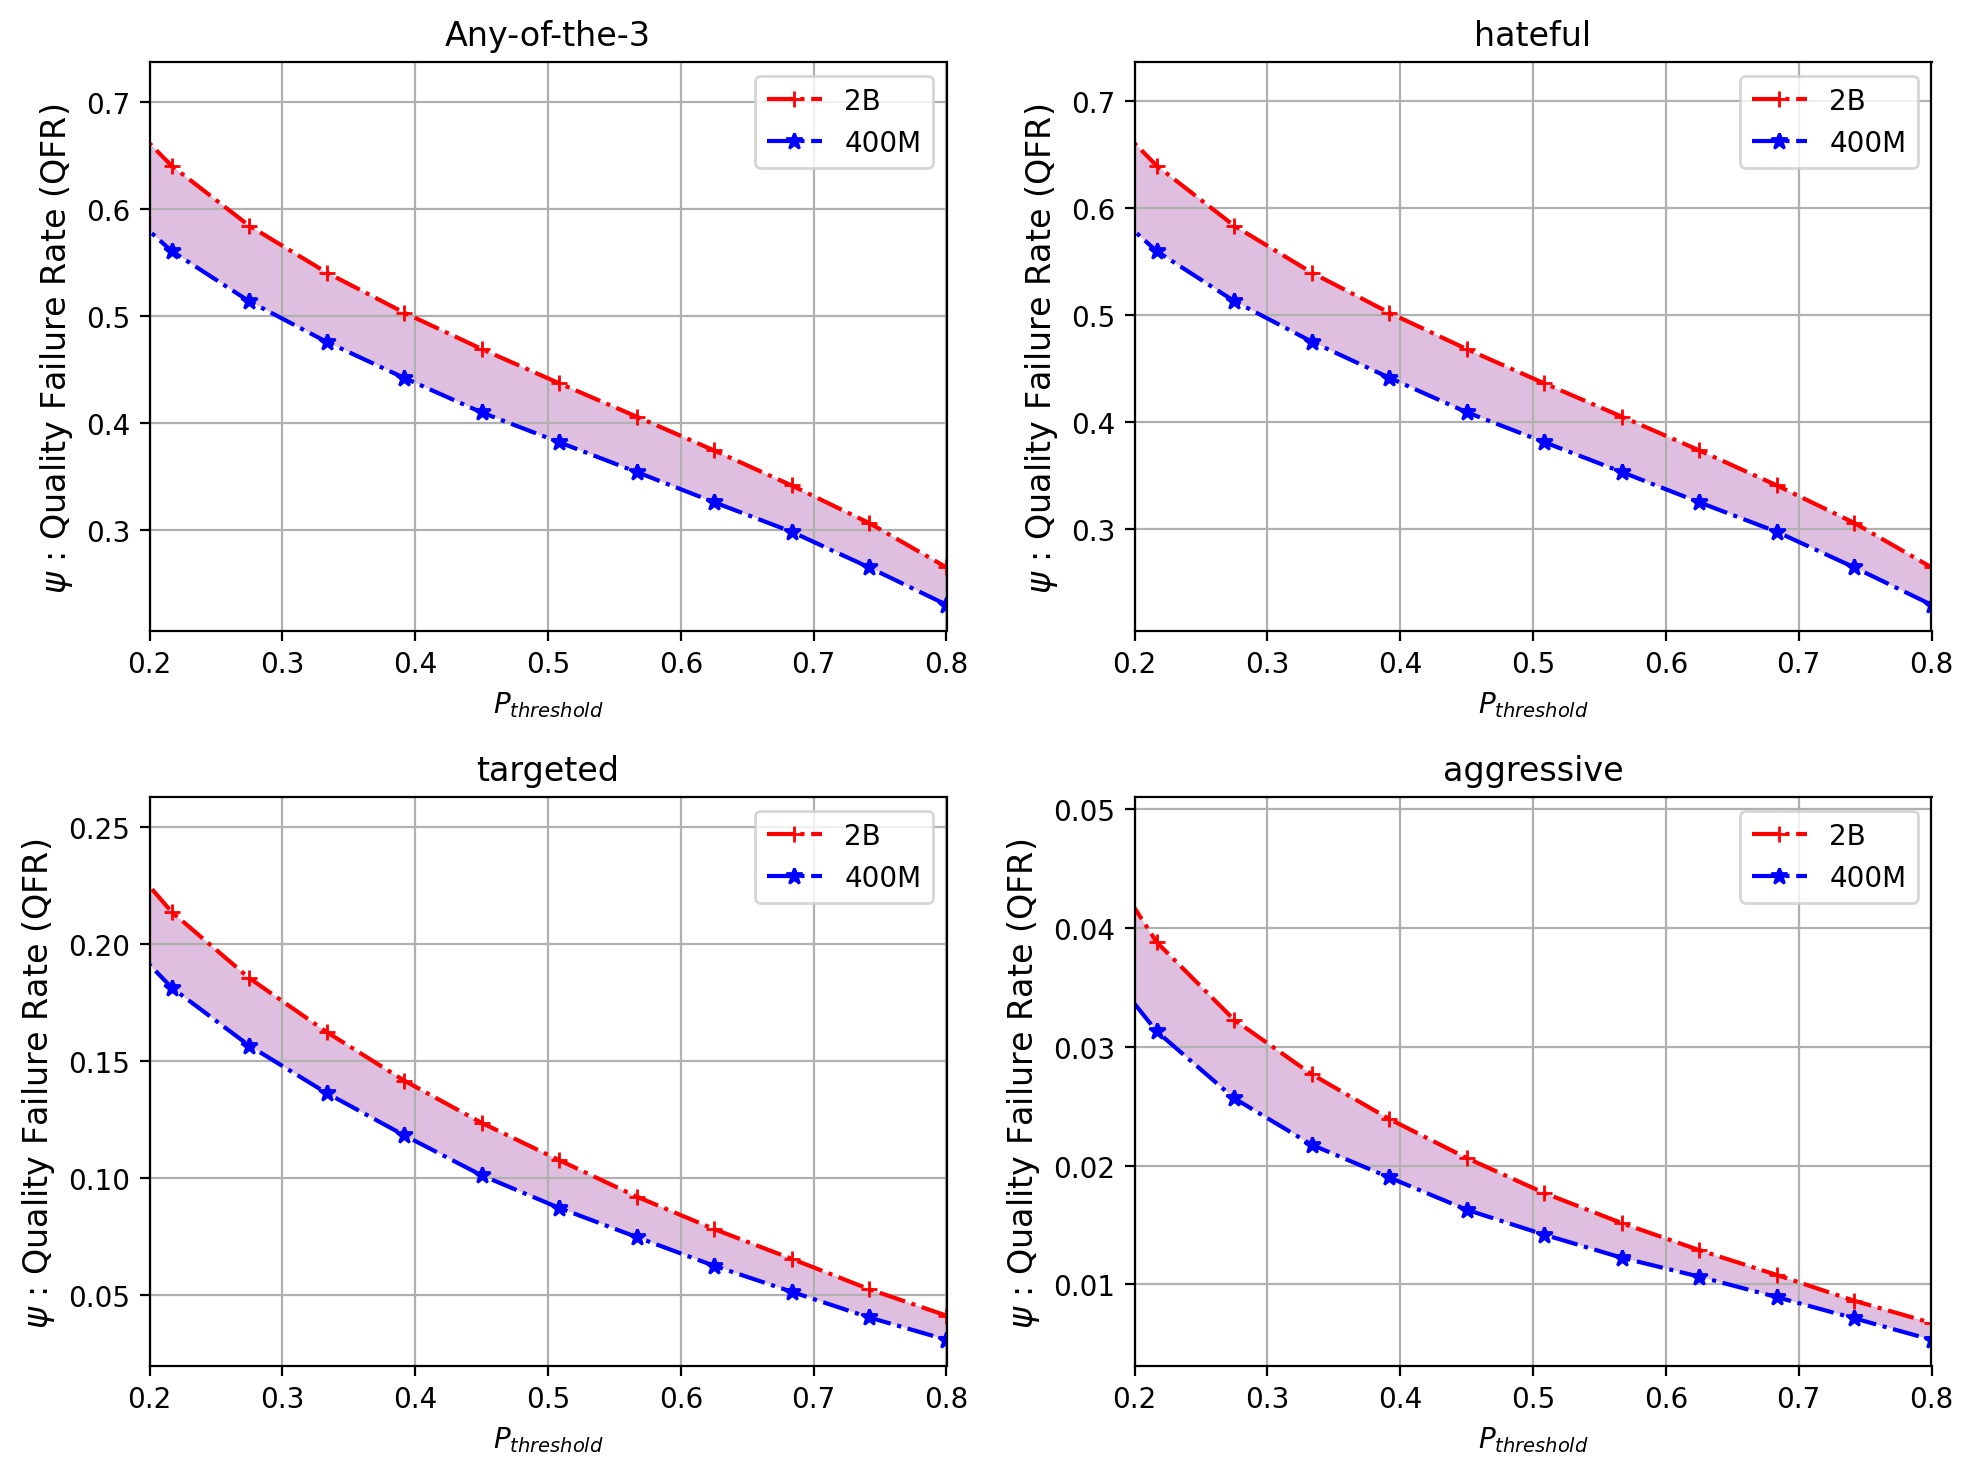

In [ ]:
thresh_vec=np.linspace(0.1,0.8,13)

type_vec=['hateful','targeted','aggressive']


p_detect=[]
for t in thresh_vec :
  p_detect.append(((np.max(p_400m,axis=1)>=t).mean()*100,(np.max(p_2b,axis=1)>=t).mean()*100))

p_detect_mat=np.array(p_detect)


plt.figure(figsize=(10,7.5))
plt.subplot(2,2,1)
plt.plot(thresh_vec[1:],p_detect_mat[1:,1],'-.r+',label='2B')
plt.plot(thresh_vec[1:],p_detect_mat[1:,0],'-.b*',label='400M')
plt.fill_between(thresh_vec[1:],p_detect_mat[1:,1],p_detect_mat[1:,0],facecolor='purple',alpha=0.25)
plt.ylabel(r'$\psi$ : Quality Failure Rate (QFR) ',fontsize=12)
plt.xlim([0.2,0.8])
plt.xlabel(r'$P_{threshold}$')
plt.grid('on')
plt.title('Any-of-the-3')
plt.legend()

for col in range(3):
  p_detect=[]
  for t in thresh_vec :
    p_detect.append(((p_400m[:,col]>=t).mean()*100,(p_2b[:,col]>=t).mean()*100))

  p_detect_mat=np.array(p_detect)
  plt.subplot(2,2,col+2)
  plt.plot(thresh_vec[1:],p_detect_mat[1:,1],'-.r+',label='2B')
  plt.plot(thresh_vec[1:],p_detect_mat[1:,0],'-.b*',label='400M')
  plt.fill_between(thresh_vec[1:],p_detect_mat[1:,1],p_detect_mat[1:,0],facecolor='purple',alpha=0.25)
  
  plt.ylabel(r'$\psi$ : Quality Failure Rate (QFR) ',fontsize=12)
  plt.xlabel(r'$P_{threshold}$')
  plt.title(type_vec[col])
  plt.legend()
  plt.grid('on')
  plt.xlim([0.2,0.8])

plt.tight_layout()

# plt.savefig('p_detect.pdf',bbox_inches='tight')
# plt.savefig('p_detect.png')

## $4(b) : The underestimation of QFR demonstration

This experiment demonstrates the perils of lazily extending QFR-results obtained from the 400M dataset to 2B-en dataset.

Let us begin by evaluating the basic stats of the probability-matrices for the two datasets ...

In [ ]:
from scipy.stats import describe
[describe(p_400m,axis=0), 
 describe(p_2b,axis=0),
 describe(np.max(p_400m,axis=1)>0.5),
 describe(np.max(p_2b,axis=1)>0.5),
(np.max(p_400m,axis=1)>0.5).sum(),(np.max(p_2b,axis=1)>0.5).sum()]

[DescribeResult(nobs=3200000, minmax=(array([0.003968, 0.00101 , 0.001529]), array([0.997404, 0.991653, 0.982416])), mean=array([0.011083, 0.005196, 0.003977]), variance=array([0.00281 , 0.000625, 0.000107]), skewness=array([14.950273, 27.279172, 64.243515]), kurtosis=array([ 235.237175,  827.533348, 4693.846531])),
 DescribeResult(nobs=12800000, minmax=(array([0.003871, 0.00092 , 0.001531]), array([0.997459, 0.993499, 0.983851])), mean=array([0.011663, 0.005351, 0.004019]), variance=array([0.003223, 0.00077 , 0.000133]), skewness=array([14.013766, 25.174823, 57.613004]), kurtosis=array([ 206.186839,  700.476831, 3779.74378 ])),
 DescribeResult(nobs=3200000, minmax=(False, True), mean=0.0038590625, variance=0.0038441713379246405, skewness=16.004192199654522, kurtosis=254.1341679634835),
 DescribeResult(nobs=12800000, minmax=(False, True), mean=0.004417890625, variance=0.004398373211048441, skewness=14.94512644539241, kurtosis=221.3568044687685),
 12349,
 56549]

There appears to be a marked increase in the mean values :(
To check the validity of this observation, let us estimate CIs (Confidence Intervals) for this binomial proportion observation set

In [ ]:
from statsmodels.stats.proportion import proportion_confint

u_400m=np.mean(np.max(p_400m,axis=1)>0.5)*100 # QFR at 0.5 for the 400M dataset
u_2b=np.mean(np.max(p_2b,axis=1)>0.5)*100# QFR at 0.5 for the 2B-en dataset

ci_400m=np.array(proportion_confint(count=12349,nobs=3200000,alpha=0.05,method='wilson'))*100
ci_2b=np.array(proportion_confint(count=56549,nobs=12800000,alpha=0.05,method='wilson'))*100

u_400m,ci_400m,u_2b,ci_2b

(0.38590625,
 array([0.379172, 0.392759]),
 0.44178906250000005,
 array([0.438171, 0.445437]))

Wow!
Let estimate the percentage increase b/w the 2B-en and 400M datasets as $\frac{CI_{lower,2B}-CI_{upper,400M}}{CI_{upper,400M}}$

In [ ]:
perc_increase=((ci_2b[0]-ci_400m[1])/ci_400m[1])*100
perc_increase

11.562156409730925

In [ ]:
n_400m=413e6
n_2b=2.32e9

ci_toxic_400m=n_400m*np.array(ci_400m)/100
ci_toxic_2b=n_2b*np.array(ci_2b)/100
ci_misestimate=n_2b*np.array(ci_400m)/100

print(ci_toxic_400m, ci_toxic_2b , ci_misestimate )

[1565981.815529 1622095.770604] [10165560.40693  10334142.205234] [8796798.576337 9112014.982568]


Moving from CIs to estimating the number of excess toxic-images:

In [ ]:
n_diff=int(((n_2b*ci_2b[0])-(n_2b*ci_400m[1]))/100)
n_diff

1053545

In [ ]:
# mid-point analysis:
[u_400m,u_2b],[np.diff(ci_400m)[0]/2,np.diff(ci_2b)[0]/2]

([0.38590625, 0.44178906250000005],
 [0.006793457030833838, 0.0036332284117203684])

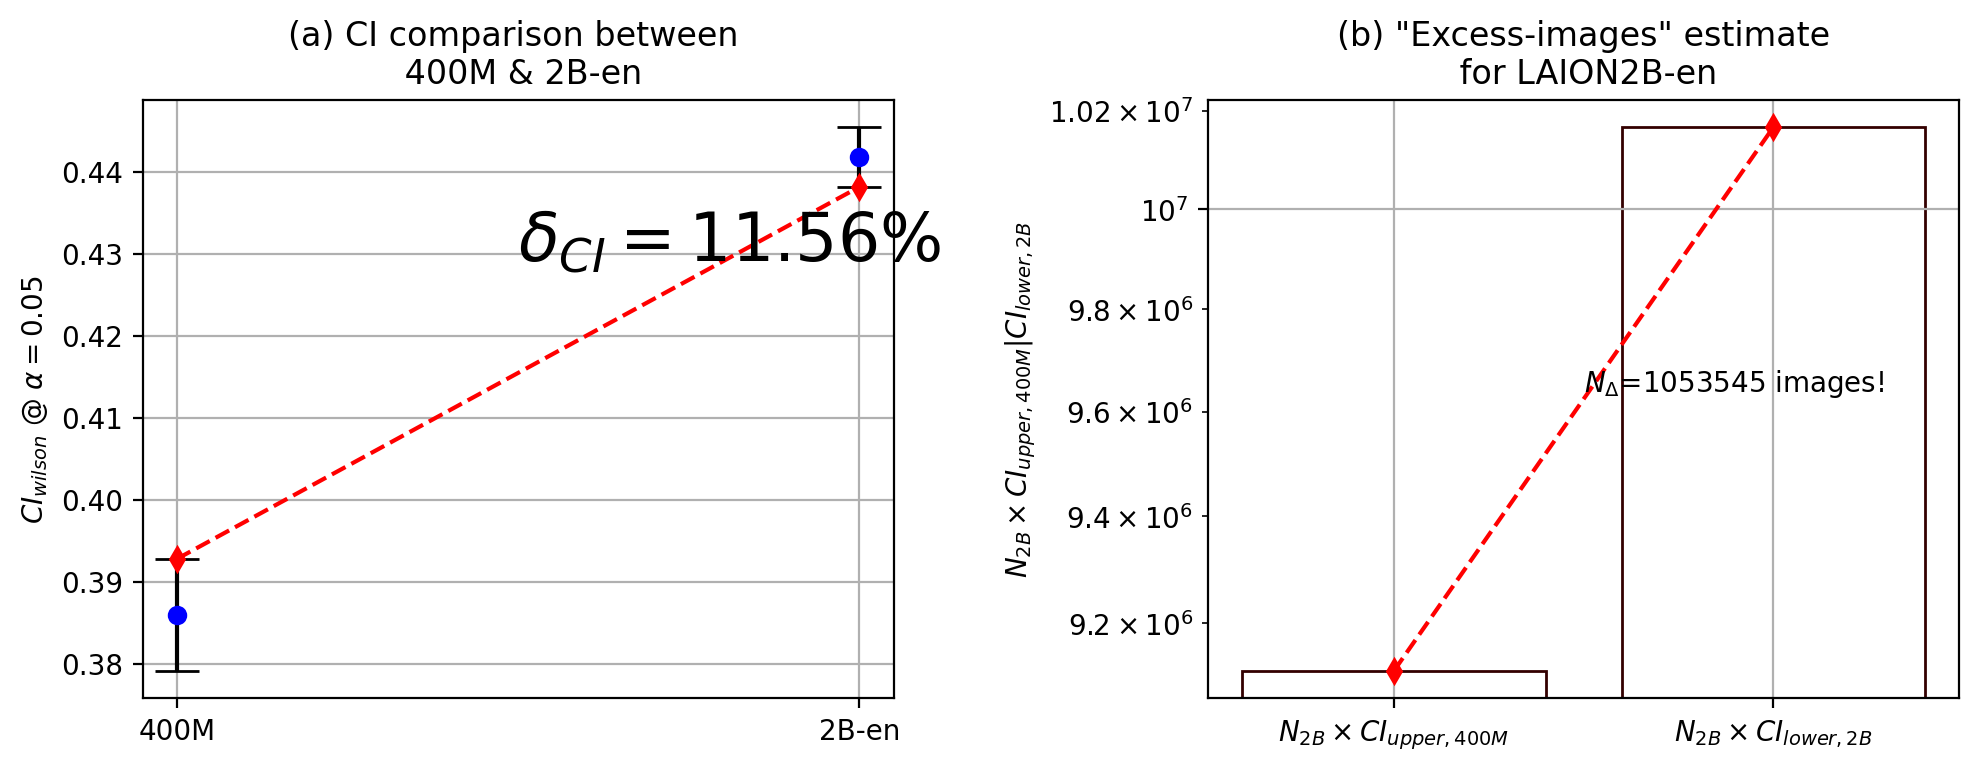

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.errorbar([0,1],[u_400m,u_2b],[np.diff(ci_400m)[0]/2,np.diff(ci_2b)[0]/2],linestyle='None',  fmt="ob",  capsize=8,  ecolor="k")
plt.xticks([0,1],['400M','2B-en'])
plt.ylabel(r'$CI_{wilson}$ @ $\alpha=0.05$')
plt.grid('on')
point1 = [0, ci_400m[1]]
point2 = [1, ci_2b[0]]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'rd', linestyle="--")
plt.text(point2[0]-0.5, point2[1]-0.009, r"$\delta_{CI}=11.56$%",fontsize=24)
plt.title('(a) CI comparison between \n 400M & 2B-en')


plt.subplot(122)
# plt.errorbar([0,1],[int(n_400m*u_400m),int(n_2b*u_2b)],[int(n_400m*np.diff(ci_400m)[0]/2),int(n_2b*np.diff(ci_2b)[0]/2)],linestyle='None',  fmt="ob",  capsize=8,  ecolor="k")
plt.bar([0,1],[int(n_2b*ci_400m[1]/100),int(n_2b*ci_2b[0])/100],fill=False,color='#330000',edgecolor='#330000')
plt.xticks([0,1],[r'$N_{2B} \times CI_{upper,400M}$',r'$N_{2B} \times CI_{lower,2B}$'])
# plt.xticks([0,1],['400M','2B-en'])
plt.semilogy()

plt.grid('on')
plt.ylabel(r'$N_{2B} \times CI_{upper,400M} | CI_{lower,2B}$')
point1 = [0, int(n_2b*ci_400m[1]/100)]
point2 = [1, int(n_2b*ci_2b[0]/100)]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'rd', linestyle="--")
plt.text(0.5, point1[1]+(point2[1]-point1[1])/2, rf"$N_{{\Delta}}$={n_diff} images!")
plt.title('(b) "Excess-images" estimate\n for LAION2B-en')
plt.tight_layout()
plt.savefig('n_excess.pdf',bbox_inches='tight')
plt.savefig('n_excess.png')

# plt.subplot(122)
# plt.errorbar([0,1],[u_400m,u_2b],[np.diff(ci_400m)[0],np.diff(ci_2b)[0]],capsize=3)
# plt.xticks([0,1],['400M','2B-en'])

## $4(c): Intra-dataset filewise comparisons (Welch separate variances T-testframework)

Given that the two datasets, LAION-400M and LAION-2B-En, are split into 32 (and 128)
purportedly uniformly sampled shards, respectively, we now examine the validity of the filelevel QFR metrics to the global dataset-level metrics. We use the 0.1 million × 3 sized
file-level text-quality score matrices obtained from the Pysentimiento model and compute
what fraction of these rows are greater than Pthreshold of 0.5 for all the 3 columns. This yields
file-level QFRs (in%) for each of the two datasets with the 3 columns mapping to hateful
speech, targeted speech and aggressive speech.

In [ ]:
!pip install --quiet pingouin
# # https://ethanweed.github.io/pythonbook/05.02-ttest.html#the-independent-samples-t-test-welch-test

In [ ]:
from pingouin import ttest
p_400m_max=np.max(p_400m,axis=1)
p_2b_max=np.max(p_2b,axis=1)
describe(p_400m_max),describe(p_2b_max)
ttest(p_2b_max,p_400m_max, correction = False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,16.530828,15999998,two-sided,2.203586e-61,"[0.0, 0.0]",0.010332,1.539e+56,1.0


 Hand-estimate Cohen's-d to verify the pingouin generated one (~0.0103)

In [ ]:
n1=len(p_2b_max)
n2=len(p_400m_max)

u1=np.mean(p_2b_max)
u2=np.mean(p_400m_max)

s1=np.var(p_2b_max)
s2=np.var(p_400m_max)

s = np.sqrt(((n1) * s1 + (n2) * s2) / (n1 + n2 - 2))

# calculate Cohen's d
d = (u1 - u2) / s
d

0.010331767421212263

In [ ]:
p_05_400m=(p_400m>0.5)
res = np.logical_or.reduce(p_05_400m, 1).astype(np.int32)
res.shape,res.mean()

((3200000,), 0.0038590625)

File-level analysis: 

First let us load the file-level meta-datasets

In [ ]:
prob_mat_2b=np.load('./hate_detect_2B-en/prob_mat_all.npy')
prob_mat_400m=np.load(f'./hate_detect_400m/prob_mat_all.npy')
prob_mat_400m.shape,prob_mat_2b.shape,describe(prob_mat_400m[:,0]),describe(prob_mat_2b[:,0])

((32, 3),
 (128, 3),
 DescribeResult(nobs=32, minmax=(0.349, 0.43099999999999994), mean=0.38540625, variance=0.00040147479838709686, skewness=0.30578132513735945, kurtosis=-0.5462518499155964),
 DescribeResult(nobs=128, minmax=(0.4, 0.483), mean=0.441171875, variance=0.00033006471456692893, skewness=0.16517689236774552, kurtosis=-0.44234974682828687))

Now, let us see what percentage of the files fall within 2 SD of the population mean

In [ ]:
coverage_400m=[]
for i in range(3):
  u_i=prob_mat_400m[:,i].mean()
  s_i=prob_mat_400m[:,i].std()
  coverage_400m.append(np.mean(((u_i-2*s_i) < prob_mat_400m[:,i]) & (prob_mat_400m[:,i]<(u_i+2*s_i))))

coverage_2b=[]
for i in range(3):
  u_i=prob_mat_2b[:,i].mean()
  s_i=prob_mat_2b[:,i].std()
  coverage_2b.append(np.mean(((u_i-2*s_i) < prob_mat_2b[:,i]) & (prob_mat_2b[:,i]<(u_i+2*s_i))))

coverage_400m,coverage_2b

([0.96875, 0.9375, 0.96875], [0.953125, 0.953125, 0.9375])

Neat! Now, we perform a two-sample t-test while correcting for unequal variances (using the
Welch separate variances T-test) and explicitly setting the alternative hypothesis set to be
‘greater’ (with respect to the alternate hypothesis that the mean of the 2B-en QFRs is greater than the mean of 400M-QFRs)

In [ ]:
df_t0=ttest(prob_mat_2b[:,0],prob_mat_400m[:,0], correction = True,alternative='greater')
df_t1=ttest(prob_mat_2b[:,1],prob_mat_400m[:,1], correction = True,alternative='greater')
df_t2=ttest(prob_mat_2b[:,2],prob_mat_400m[:,2], correction = True,alternative='greater')

df_t=pd.concat([df_t0,df_t1,df_t2],ignore_index=True)
df_t.index=['hateful','targeted','aggressive']
df_t

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
hateful,14.339134,44.592762,greater,1.299661e-18,"[0.05, inf]",3.006351,1.594e+27,1.000000
targeted,12.222288,60.561053,greater,2.693412e-18,"[0.02, inf]",2.058092,3.416e+21,1.000000
aggressive,4.629727,48.457177,greater,1.383498e-05,"[0.0, inf]",0.903662,4293.568,0.998179


OK. So, this needs to be prettied up for the tables that appear in the paper ...

In [ ]:
pd.options.display.precision==2
df_t.iloc[:,[0,1,5,6]]=np.round(df_t.iloc[:,[0,1,5,6]],2)
print(df_t.iloc[:,[0,1,3,5,6]].to_latex())

\begin{tabular}{lrrrrl}
\toprule
{} &      T &    dof &         p-val &  cohen-d &       BF10 \\
\midrule
hateful    &  14.34 &  44.59 &  1.299661e-18 &     3.01 &  1.594e+27 \\
targeted   &  12.22 &  60.56 &  2.693412e-18 &     2.06 &  3.416e+21 \\
aggressive &   4.63 &  48.46 &  1.383498e-05 &     0.90 &   4293.568 \\
\bottomrule
\end{tabular}



<ipython-input-33-cd5b4c3920df>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_t.iloc[:,[0,1,3,5,6]].to_latex())


In [ ]:
print(df_t.to_latex())

\begin{tabular}{lrrlrlrlr}
\toprule
{} &      T &    dof & alternative &         p-val &        CI95\% &  cohen-d &       BF10 &     power \\
\midrule
hateful    &  14.34 &  44.59 &     greater &  1.299661e-18 &  [0.05, inf] &     3.01 &  1.594e+27 &  1.000000 \\
targeted   &  12.22 &  60.56 &     greater &  2.693412e-18 &  [0.02, inf] &     2.06 &  3.416e+21 &  1.000000 \\
aggressive &   4.63 &  48.46 &     greater &  1.383498e-05 &   [0.0, inf] &     0.90 &   4293.568 &  0.998179 \\
\bottomrule
\end{tabular}



<ipython-input-34-a389fe1a1304>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_t.to_latex())


### Final step:  

Generating Fused swarm-box-violinplot that captures the file-wise QFR metrics for all the 160
(=32+128) parquet files from LAION400M and LAION-2B-En

In [ ]:
df_files_400m=pd.DataFrame(data=np.ravel(prob_mat_400m),columns=['p_sentimento'])
df_files_400m['type']=['P_hateful', 'P_targeted', 'P_aggressive']*32
df_files_400m['dataset']='400M'
df_files_400m

,p_sentimento,type,dataset
0,0.349,P_hateful,400M
1,0.078,P_targeted,400M
2,0.013,P_aggressive,400M
3,0.375,P_hateful,400M
4,0.098,P_targeted,400M
...,...,...,...
91,0.078,P_targeted,400M
92,0.018,P_aggressive,400M
93,0.367,P_hateful,400M
94,0.093,P_targeted,400M


In [ ]:
df_files_2b=pd.DataFrame(data=np.ravel(prob_mat_2b),columns=['p_sentimento'])
df_files_2b['type']=['P_hateful', 'P_targeted', 'P_aggressive']*128
df_files_2b['dataset']='2B-En'
df_files_2b

,p_sentimento,type,dataset
0,0.467,P_hateful,2B-En
1,0.093,P_targeted,2B-En
2,0.013,P_aggressive,2B-En
3,0.422,P_hateful,2B-En
4,0.099,P_targeted,2B-En
...,...,...,...
379,0.098,P_targeted,2B-En
380,0.018,P_aggressive,2B-En
381,0.445,P_hateful,2B-En
382,0.100,P_targeted,2B-En


In [ ]:
df_comb=pd.concat([df_files_400m,df_files_2b],ignore_index=True)
df_comb

,p_sentimento,type,dataset
0,0.349,P_hateful,400M
1,0.078,P_targeted,400M
2,0.013,P_aggressive,400M
3,0.375,P_hateful,400M
4,0.098,P_targeted,400M
...,...,...,...
475,0.098,P_targeted,2B-En
476,0.018,P_aggressive,2B-En
477,0.445,P_hateful,2B-En
478,0.100,P_targeted,2B-En


<ipython-input-38-f10a679793dc>:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('blue')
<ipython-input-38-f10a679793dc>:36: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('red')


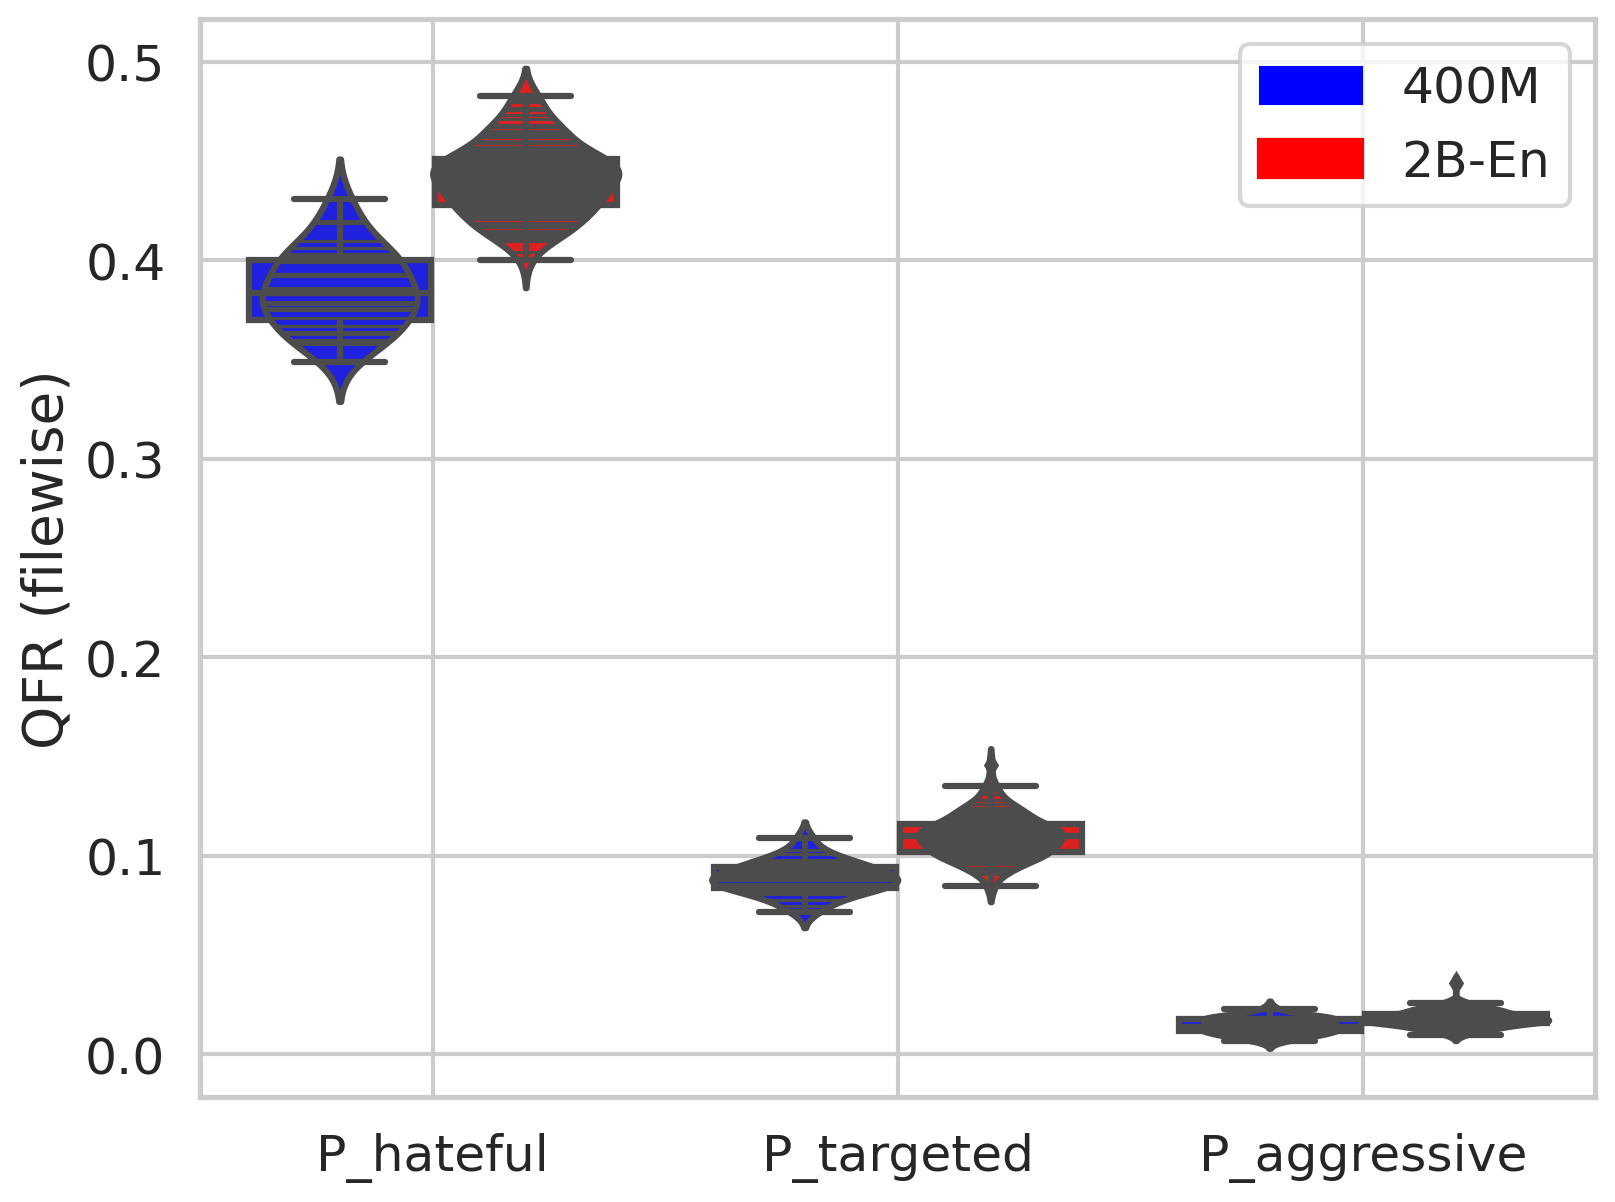

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(9,7))
g=sns.violinplot(x = "type",
            y = "p_sentimento",
            hue="dataset",
            inner='stick',
            data = df_comb,legend='False',
            palette=sns.color_palette(['blue', 'red']))

# ax=sns.swarmplot(y='p_sentimento',hue='dataset',x='type',data=df_comb,zorder=0)
g=sns.boxplot(x = "type",
            y = "p_sentimento",
            hue="dataset",
            data = df_comb,
            palette=sns.color_palette(['blue', 'red'])
            )
# sns.swarmplot(x = "type",split=True,
#             y = "p_sentimento",color="white",
#             hue="dataset",
#             data = df_comb, dodge=True,
#             palette=sns.color_palette(['blue', 'red']))
# sns.stripplot(x = "type",
#             y = "p_sentimento",
#             hue="dataset",
#             data = df_comb)
# plt.ylabel(r'$\bar{p}_{sentimiento}$ (filewise)')
plt.ylabel(r'QFR (filewise)')
plt.xlabel('')

plt.legend(['400M','2B-En'])
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
plt.grid('on')

# # Draw a nested violinplot and split the violins for easier comparison
# sns.boxplot(data=df_comb, hue="dataset", y="p_sentimento", x="type", showcaps=False,boxprops={'facecolor':'None'},
#                  showfliers=False,whiskerprops={'linewidth':0}, ax=ax)#,split=True,bw=.2,scale="count")
# # sns.swarmplot(data=df_comb, hue="dataset", y="p_sentimento", x="type")
# plt.grid('on')
# # plt.semilogy()
# plt.xlabel('')
# plt.ylabel(r'$p_{sentimento}$ in %')
# sns.despine(left=True)
# plt.savefig('filewise_violin.pdf',bboxes_inches='tight')
# plt.savefig('filewise_violin.png',bboxes_inches='tight')